In [6]:
# Necessary libraries

import os
import io
import re
import sys
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder

np.random.seed(42)
sns.set(style='whitegrid')

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('wordnet')

import spacy
import random
import numpy as np
import contractions
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import layers, optimizers
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, f1_score, classification_report, confusion_matrix, make_scorer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hsina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hsina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Import dataset

data = pd.read_csv('./ai_human.csv')
df_0 = data[data["generated"] == 0].sample(n=50000, random_state=42)
df_1 = data[data["generated"] == 1].sample(n=50000, random_state=42)
df = pd.concat([df_0, df_1]).sample(frac=1, random_state=42).reset_index(drop=True)
df.head(5)

,text,generated
0,"In recent years, advances in technology have m...",1.0
1,"When looking at a product, it is important to ...",1.0
2,"Dear President of the United States,\n\nI thin...",0.0
3,"Music, drama, and art classes have a Side vari...",1.0
4,After careful research oi the options availabl...,1.0


### **EXPLORATORY DATA ANALYSIS**

Dataset Information
Dataset shape:  (100000, 2)
Dataset columns:  Index(['text', 'generated'], dtype='object')
------------------------------
Class Distribution:  generated
1.0    50000
0.0    50000
Name: count, dtype: int64
------------------------------
Data types in columns
text          object
generated    float64
dtype: object


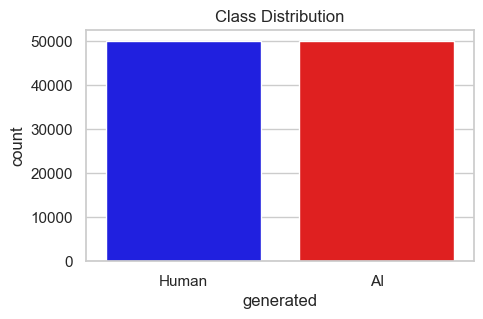

In [3]:
# --- Data Information ---

print('Dataset Information')
print('Dataset shape: ', df.shape)
print('Dataset columns: ', df.columns)

# --- Class Distribution ---
print('-'*30)
print('Class Distribution: ', df['generated'].value_counts())

# --- Data Types ---
print('-'*30)
print('Data types in columns')
print(df.dtypes)

# --- Plot ---
plt.figure(figsize=(5,3))

sns.countplot(
    x='generated', 
    data=df, 
    palette={'0.0': 'blue', '1.0': 'red'}  # 0 → Human, 1 → AI
)

plt.xticks([0,1], ['Human','AI'])
plt.title('Class Distribution')
plt.show()

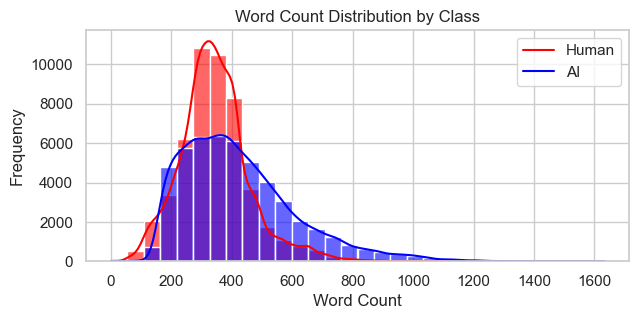

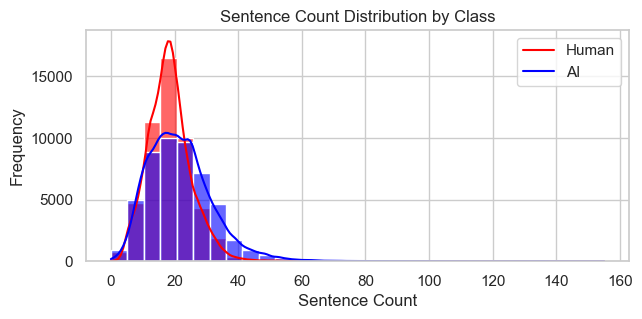

In [7]:
# --- Text Length Analysis ---
df_copy = df.copy()

# ----- Text Cleaning ---
def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# --- Word & Sentence Count ---
df_copy['clean_text'] = df_copy['text'].apply(clean_text)
df_copy['word_count'] = df_copy['clean_text'].apply(lambda x: len(x.split()))
df_copy['sentence_count'] = df_copy['text'].apply(lambda x: len(re.split(r'[.!?]+', x)) - 1)

# --- Plots ---

# Word Count
plt.figure(figsize=(7,3))
sns.histplot(df_copy, x='word_count', hue='generated', bins=30, kde=True,
             palette={0: 'blue', 1: 'red'}, alpha=0.6)
plt.title('Word Count Distribution by Class')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend(labels=['Human','AI'])
plt.show()

# Sentence Count
plt.figure(figsize=(7,3))
sns.histplot(df_copy, x='sentence_count', hue='generated', bins=30, kde=True,
             palette={0: 'blue', 1: 'red'}, alpha=0.6)
plt.title('Sentence Count Distribution by Class')
plt.xlabel('Sentence Count')
plt.ylabel('Frequency')
plt.legend(labels=['Human','AI'])
plt.show()


In [8]:
# --- Missing Values Check ---

missing = df.isna().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'missing_count': missing,
    'missing_percent': missing_percent
})
print(missing_df)

           missing_count  missing_percent
text                   0              0.0
generated              0              0.0


### **Natural Language Processing (NLP) for AI vs Human Text Detector**

In [9]:
# Build a function to clean texts

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)

In [10]:
# Create a dataset with cleaned texts
df['clean_text'] = df['text'].apply(clean_text)
df.head(5)

,text,generated,clean_text
0,"In recent years, advances in technology have m...",1.0,recent year advance technology made possible c...
1,"When looking at a product, it is important to ...",1.0,looking product important honest consumer adve...
2,"Dear President of the United States,\n\nI thin...",0.0,dear president united state think change whole...
3,"Music, drama, and art classes have a Side vari...",1.0,music drama art class side variety benefit off...
4,After careful research oi the options availabl...,1.0,careful research oi option available reach des...


### **MACHINE LEARNING ALGORITHMS**

**Preparation of the Data**

In [12]:
# --- Test & Training Data ---
X = df['clean_text']
y = df['generated']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- TF-IDF Vectorizer --- 
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

### **1. Multinomial Naive Bayes (MNB)**

Best Parameters for MNB Model: {'alpha': 0.01, 'fit_prior': True}
------------------------------
🔵 MNB Accuracy (Train) : 0.946
🟢 MNB Accuracy (Test)  : 0.947
🔵 MNB F1 Score (Train) : 0.945
🟢 MNB F1 Score (Test)  : 0.945
------------------------------
Classification Report of MNB:

              precision    recall  f1-score   support

         0.0      0.928     0.968     0.948     10000
         1.0      0.967     0.925     0.945     10000

    accuracy                          0.947     20000
   macro avg      0.947     0.947     0.946     20000
weighted avg      0.947     0.947     0.946     20000

------------------------------
Confusion Matrix of MNB:



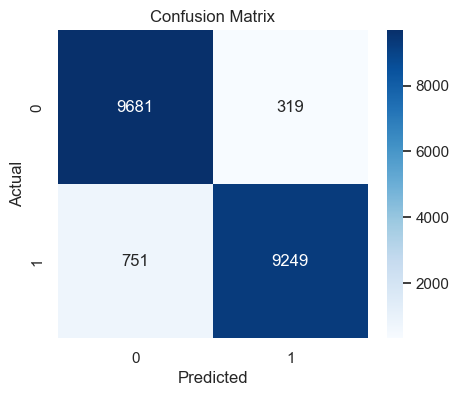

In [13]:
# --- Build the model ---
mnb_model = MultinomialNB()

# --- Hyperparameter tuning ---
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 1.5, 2.0],
    'fit_prior': [True, False]
}
grid = GridSearchCV(estimator=mnb_model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=0)
grid.fit(X_train_tfidf, y_train)
print("Best Parameters for MNB Model:", grid.best_params_)
best_mnb = grid.best_estimator_
print('-'*30)

# --- Predictions ---
y_pred_mnb = best_mnb.predict(X_test_tfidf)
y_pred_mnb_train = best_mnb.predict(X_train_tfidf)

# --- Performance metrics ---
acc_mnb = round(accuracy_score(y_test, y_pred_mnb),3)
f1_mnb = round(f1_score(y_test, y_pred_mnb),3)
acc_train_mnb = accuracy_score(y_train, y_pred_mnb_train)
f1_train_mnb = f1_score(y_train, y_pred_mnb_train)

# --- Confusion Matrix ---
cm_mnb = confusion_matrix(y_test, y_pred_mnb)

# --- Print results ---
print(f"🔵 MNB Accuracy (Train) : {acc_train_mnb:.3f}")
print(f"🟢 MNB Accuracy (Test)  : {acc_mnb:.3f}")
print(f"🔵 MNB F1 Score (Train) : {f1_train_mnb:.3f}")
print(f"🟢 MNB F1 Score (Test)  : {f1_mnb:.3f}")
print('-'*30)
print('Classification Report of MNB:\n')
print(classification_report(y_test, y_pred_mnb, digits=3))
print('-'*30)
print('Confusion Matrix of MNB:\n')
plt.figure(figsize=(5,4))
sns.heatmap(cm_mnb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

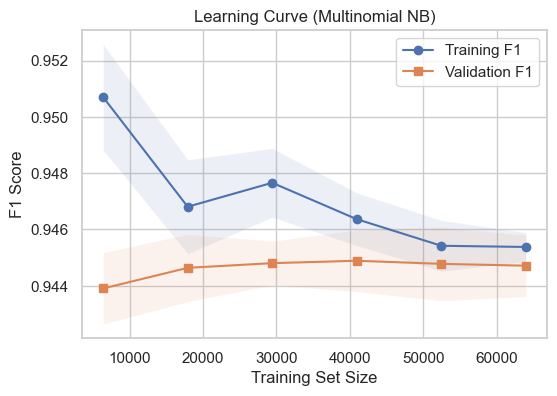

In [14]:
# --- Overfitting Control Step 2: Learning Curve ---

train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_mnb,
    X=X_train_tfidf,
    y=y_train,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6)
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, marker='o', label='Training F1')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)

plt.plot(train_sizes, val_mean, marker='s', label='Validation F1')
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1)

plt.title('Learning Curve (Multinomial NB)')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

**Overfitting Control Results for Multinomial Naive Bayes (MNB)**    
**Training vs Test Scores:**
- Train F1: 0.945  
- Test F1: 0.945 
- Train Accuracy: 0.946
- Test Accuracy: 0.947
- Very small difference between train and test performance metrics → **no overfitting**  

**Learning Curve Insights:**
- Train & validation F1 increase with more data, stabilizing around **0.945**  
- Minimal gap between curves → model **generalizes well**  
- Slight validation fluctuations are normal for smaller training sizes  

**Conclusion:**  
The Multinomial Naive Bayes model shows **high, stable performance** and **good generalization**. Additional data may yield minor improvements, but overfitting is not observed.

### **LINEAR SUPPORT VECTOR CLASSIFICATION (LinearSVC)**

Best Parameters for LinearSVC:  {'C': 10, 'dual': False}
🔵 SVC Accuracy (Train) : 0.999
🟢 SVC Accuracy (Test)  : 0.994
🔵 SVC F1 Score (Train) : 0.999
🟢 SVC F1 Score (Test)  : 0.994
------------------------------
Classification Report of SVC:

              precision    recall  f1-score   support

         0.0      0.994     0.994     0.994     10000
         1.0      0.994     0.994     0.994     10000

    accuracy                          0.994     20000
   macro avg      0.994     0.994     0.994     20000
weighted avg      0.994     0.994     0.994     20000

------------------------------
Confusion Matrix of SVC:



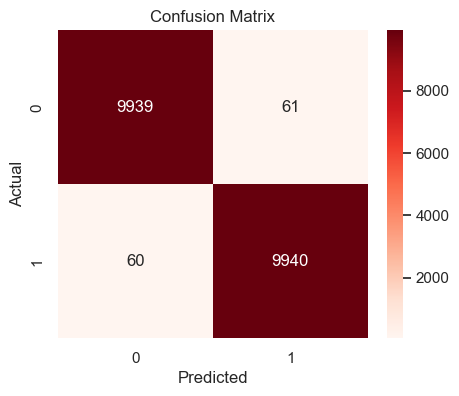

In [15]:
# --- Build the model ---
svc = LinearSVC(random_state=42, max_iter=5000)

# --- Hyperparameter tuning ---
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'dual': [False]}
grid = GridSearchCV(svc, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=0)
grid.fit(X_train_tfidf, y_train)
print('Best Parameters for LinearSVC: ', grid.best_params_)
best_svc = grid.best_estimator_

# --- Predictions ---
y_pred_svc = best_svc.predict(X_test_tfidf)
y_pred_svc_train = best_svc.predict(X_train_tfidf)

# --- Performance metrics ---
acc_svc = round(accuracy_score(y_test, y_pred_svc),3)
f1_svc = round(f1_score(y_test, y_pred_svc),3)
acc_train_svc = accuracy_score(y_train, y_pred_svc_train)
f1_train_svc = f1_score(y_train, y_pred_svc_train)

# --- Confusion Matrix ---
cm_svc = confusion_matrix(y_test, y_pred_svc)

# --- Print results ---
print(f"🔵 SVC Accuracy (Train) : {acc_train_svc:.3f}")
print(f"🟢 SVC Accuracy (Test)  : {acc_svc:.3f}")
print(f"🔵 SVC F1 Score (Train) : {f1_train_svc:.3f}")
print(f"🟢 SVC F1 Score (Test)  : {f1_svc:.3f}")
print('-'*30)
print('Classification Report of SVC:\n')
print(classification_report(y_test, y_pred_svc, digits=3))
print('-'*30)
print('Confusion Matrix of SVC:\n')
plt.figure(figsize=(5,4))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

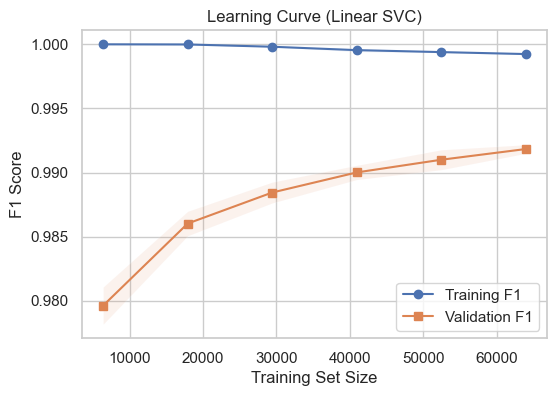

In [16]:
# --- Overfitting Control Step 2: Learning Curve ---

train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_svc,
    X=X_train_tfidf,
    y=y_train,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6)
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, marker='o', label='Training F1')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)

plt.plot(train_sizes, val_mean, marker='s', label='Validation F1')
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1)

plt.title('Learning Curve (Linear SVC)')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

**Overfitting Control Results for Linear Support Vector Classifier (Linear SVC)**    
**Training vs Test Scores:**
- Train F1: 0.999  
- Test F1: 0.994
- Train Accuracy: 0.999
- Test Accuracy: 0.994
- Small difference (~0.005) → **no significant overfitting**  

**Learning Curve Insights:**
- Train & validation F1 converge around **0.995** as training size increases  
- Minimal gap between curves → model **generalizes very well**  
- Minor validation fluctuations are normal  

**Conclusion:**  
The LinearSVC model with the current TF-IDF features shows **high, stable performance** and **excellent generalization**. Overfitting is minimal, making it reliable for the Human vs AI text classification task.

### **Lightweight Deep Learning Model**

In [17]:
# --- Prepare data ---
texts = df['clean_text'].astype(str).tolist()
labels = df['generated'].tolist()

le = LabelEncoder()
y = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, random_state=42, stratify=y)

# --- Tokenize and pad ---
max_words = 10000
max_len = 300

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# --- Build the model ---
embedding_dim = 100

model_ffn = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_ffn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_ffn.build(input_shape=(None, max_len))
model_ffn.summary()

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_pad, y_train, test_size=0.2, random_state=42, shuffle=True)

history = model_ffn.fit(
    X_train_split, y_train_split,
    validation_data=(X_val_split, y_val_split),
    epochs=20,
    batch_size=256,
    verbose=2
)

# --- Predictions ---
y_prob_ffn = model_ffn.predict(X_test_pad)
y_pred_ffn = (y_prob_ffn > 0.5).astype(int)
y_prob_train_ffn = model_ffn.predict(X_train_pad)
y_pred_train_ffn = (y_prob_train_ffn > 0.5).astype(int)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,006,529 (3.84 MB)

 Trainable params: 1,006,529 (3.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
250/250 - 9s - 38ms/step - accuracy: 0.9303 - loss: 0.2086 - val_accuracy: 0.9821 - val_loss: 0.0595
Epoch 2/20
250/250 - 8s - 30ms/step - accuracy: 0.9851 - loss: 0.0482 - val_accuracy: 0.9879 - val_loss: 0.0394
Epoch 3/20
250/250 - 8s - 31ms/step - accuracy: 0.9895 - loss: 0.0333 - val_accuracy: 0.9908 - val_loss: 0.0326
Epoch 4/20
250/250 - 8s - 30ms/step - accuracy: 0.9934 - loss: 0.0229 - val_accuracy: 0.9908 - val_loss: 0.0314
Epoch 5/20
250/250 - 8s - 31ms/step - accuracy: 0.9949 - loss: 0.0188 - val_accuracy: 0.9902 - val_loss: 0.0323
Epoch 6/20
250/250 - 8s - 30ms/step - accuracy: 0.9952 - loss: 0.0166 - val_accuracy: 0.9902 - val_loss: 0.0323
Epoch 7/20
250/250 - 8s - 31ms/step - accuracy: 0.9965 - loss: 0.0131 - val_accuracy: 0.9926 - val_loss: 0.0268
Epoch 8/20
250/250 - 8s - 30ms/step - accuracy: 0.9973 - loss: 0.0104 - val_accuracy: 0.9930 - val_loss: 0.0266
Epoch 9/20
250/250 - 8s - 30ms/step - accuracy: 0.9973 - loss: 0.0097 - val_accuracy: 0.9878 - val_loss:

🔵 FFN Accuracy (Train) : 0.998
🟢 FFN Accuracy (Test)  : 0.994
🔵 FFN F1 Score (Train) : 0.998
🟢 FFN F1 Score (Test)  : 0.994
------------------------------
Classification Report of FFN:

              precision    recall  f1-score   support

           0      0.994     0.994     0.994     10000
           1      0.994     0.994     0.994     10000

    accuracy                          0.994     20000
   macro avg      0.994     0.994     0.994     20000
weighted avg      0.994     0.994     0.994     20000

------------------------------
Confusion Matrix of FFN:



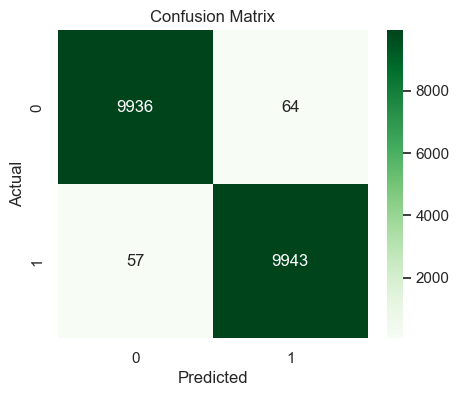

In [18]:
# --- Performance metrics of FNN ---
acc_ffn = round(accuracy_score(y_test, y_pred_ffn),3)
f1_ffn = round(f1_score(y_test, y_pred_ffn),3)
acc_train_ffn = accuracy_score(y_train, y_pred_train_ffn)
f1_train_ffn = f1_score(y_train, y_pred_train_ffn)

# --- Confusion Matrix ---
cm_ffn = confusion_matrix(y_test, y_pred_ffn)

# --- Print results ---
print(f"🔵 FFN Accuracy (Train) : {acc_train_ffn:.3f}")
print(f"🟢 FFN Accuracy (Test)  : {acc_ffn:.3f}")
print(f"🔵 FFN F1 Score (Train) : {f1_train_ffn:.3f}")
print(f"🟢 FFN F1 Score (Test)  : {f1_ffn:.3f}")
print('-'*30)
print('Classification Report of FFN:\n')
print(classification_report(y_test, y_pred_ffn, digits=3))
print('-'*30)
print('Confusion Matrix of FFN:\n')
plt.figure(figsize=(5,4))
sns.heatmap(cm_ffn, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

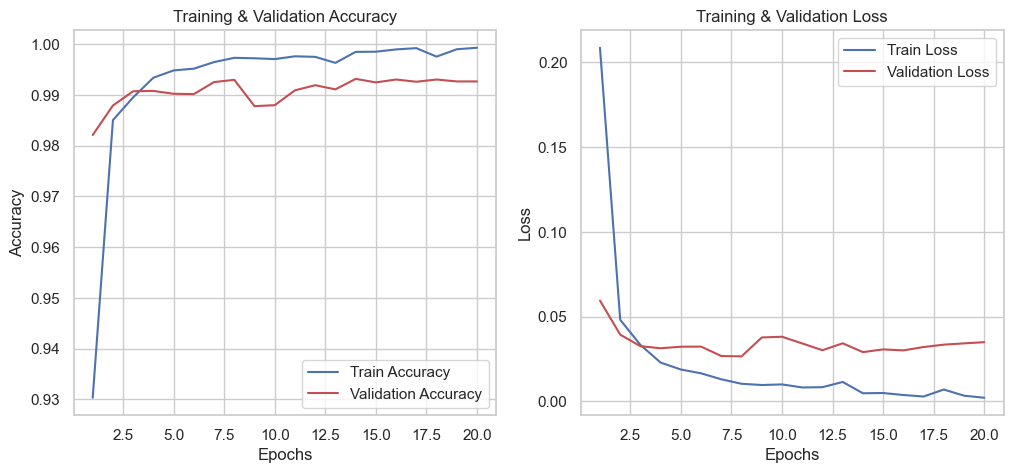

In [19]:
# --- Overfitting Control for Lightweight Deep Learning ---

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

**Lightweight Deep Learning Model Performance Summary**

**Training vs Validation Scores:**  
- Train F1: 0.999  
- Validation F1: 0.993  
- Small difference (~0.006) → **minimal overfitting**  

**Learning Curve Insights:**  
- Train & validation accuracy converge around **0.994–0.995**  
- Minor validation loss fluctuations are normal  
- Overall trend shows **strong generalization**  

**Conclusion:**  
The Lightweight Deep Learning FFN model demonstrates **high, stable performance** and **excellent generalization** for the AI vs Human text classification task. Very few misclassifications (FP=54, FN=57) make it **reliable and robust**.



### **Model Tests with Different Dataset**

In [20]:
# Import dataset

test_dataset = pd.read_csv('./ai_human_prompts.csv')
test_dataset['clean_text'] = test_dataset['text'].apply(clean_text)
test_dataset.head(5)

,text,generated,clean_text
0,"Machine learning, a subset of artificial intel...",1,machine learning subset artificial intelligenc...
1,"A decision tree, a prominent machine learning ...",1,decision tree prominent machine learning algor...
2,"Education, a cornerstone of societal progress,...",1,education cornerstone societal progress extend...
3,"Computers, the backbone of modern technology, ...",1,computer backbone modern technology revolution...
4,"Chess, a timeless game of strategy and intelle...",1,chess timeless game strategy intellect transce...


In [21]:
# Split data into x and y

x_test_dif = test_dataset['clean_text']
y_test_dif = test_dataset['generated']

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_test_seq_dif = tokenizer.texts_to_sequences(x_test_dif)

X_test_pad_dif = pad_sequences(X_test_seq_dif, maxlen=max_len, padding='post', truncating='post')

tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf_dif = tfidf.transform(x_test_dif)

y_prob_ffn_dif = model_ffn.predict(X_test_pad_dif)
y_pred_ffn_dif = (y_prob_ffn_dif > 0.5).astype(int)

y_pred_mnb_dif = best_mnb.predict(X_test_tfidf_dif)

y_pred_svc_dif = best_svc.predict(X_test_tfidf_dif)


# --- Performance metrics ---
acc_mnb_dif = round(accuracy_score(y_test_dif, y_pred_mnb_dif),3)
f1_mnb_dif = round(f1_score(y_test_dif, y_pred_mnb_dif),3)

acc_ffn_dif = round(accuracy_score(y_test_dif, y_pred_ffn_dif),3)
f1_ffn_dif = round(f1_score(y_test_dif, y_pred_ffn_dif),3)

acc_svc_dif = round(accuracy_score(y_test_dif, y_pred_svc_dif),3)
f1_svc_dif = round(f1_score(y_test_dif, y_pred_svc_dif),3)

# Results
print('Different Dataset Test Results')
print('-'*40)
print('Accuracy Results')
print('Linear SVC    : ', acc_svc_dif)
print('MNB           : ', acc_mnb_dif)
print('Deep Learning : ', acc_ffn_dif)

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Different Dataset Test Results
----------------------------------------
Accuracy Results
Linear SVC    :  0.974
MNB           :  0.99
Deep Learning :  1.0


Confusion Matrices:



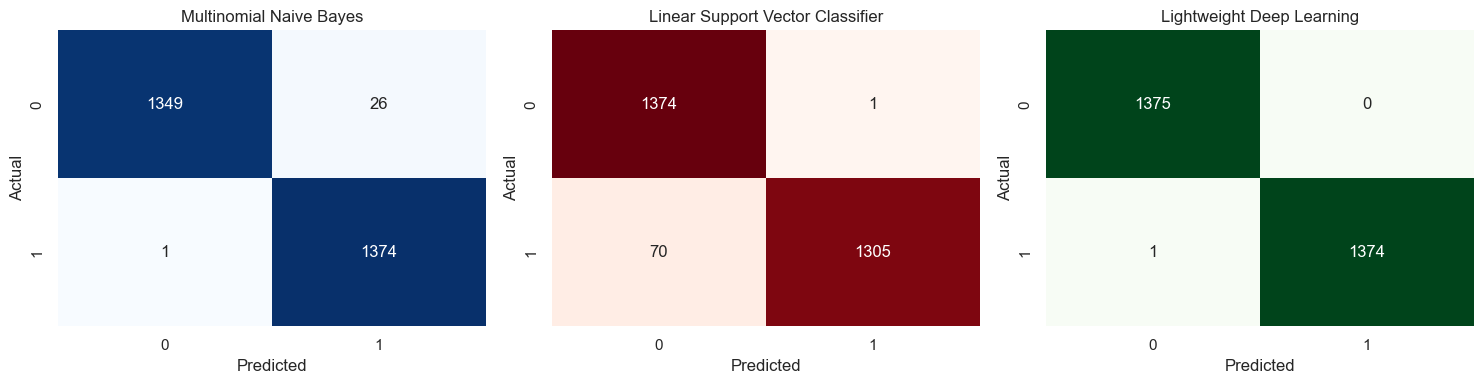

In [23]:
# --- Confusion Matrix ---
cm_mnb_dif = confusion_matrix(y_test_dif, y_pred_mnb_dif)
cm_svc_dif = confusion_matrix(y_test_dif, y_pred_svc_dif)
cm_ffn_dif = confusion_matrix(y_test_dif, y_pred_ffn_dif)

# --- Print results ---
print('Confusion Matrices:\n')
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.heatmap(cm_mnb_dif, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title("Multinomial Naive Bayes")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_svc_dif, annot=True, fmt='d', cmap='Reds', cbar=False, ax=axes[1])
axes[1].set_title("Linear Support Vector Classifier")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

sns.heatmap(cm_ffn_dif, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[2])
axes[2].set_title("Lightweight Deep Learning")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")

plt.tight_layout()
plt.show()

### **Model Prediction Comparison**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


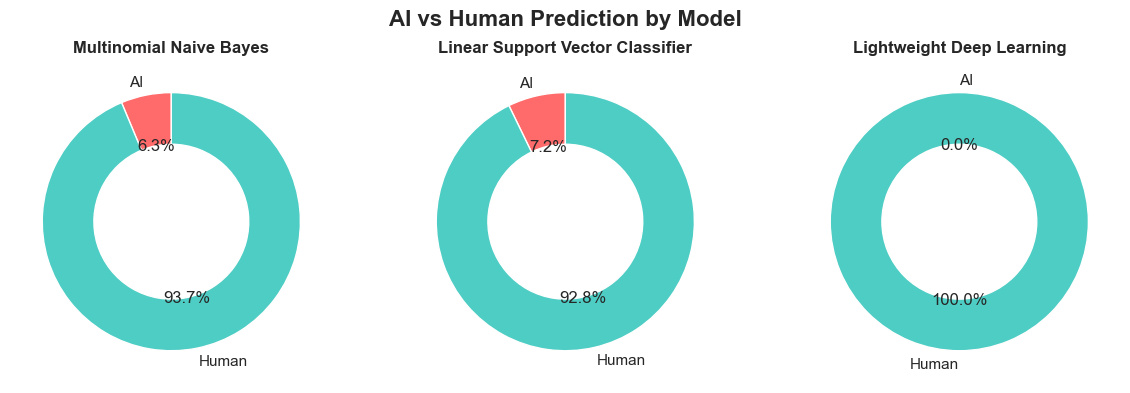

In [25]:
# --- Model Predictions ---

def model_preds(text):
    
    # Tf-Idf for MNB and SVC
    tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
    tfidf.fit(X_train)
    text_clean = clean_text(text)
    text_tfidf = tfidf.transform([text_clean])

    # Pad and Tokenizer for FFN
    seq = tokenizer.texts_to_sequences([text_clean])
    seq_pad = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

    # Vectorizer and Contreoid Calculation for Cosine Similarity
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X = vectorizer.fit_transform(df['clean_text'])
    ai_vectors = X[df['generated'] == 1]     # AI class
    human_vectors = X[df['generated'] == 0]  # Human class
    ai_centroid = np.asarray(ai_vectors.mean(axis=0)).reshape(1, -1)
    human_centroid = np.asarray(human_vectors.mean(axis=0)).reshape(1, -1)
    new_vec = vectorizer.transform([text_clean])

    # Multinomial Naive Bayes (MNB) Predictions
    mnb_probs = best_mnb.predict_proba(text_tfidf)[0]
    human_prob_mnb = mnb_probs[0]
    ai_prob_mnb = (1 - human_prob_mnb)

    # Linear Support Vector Classifier (Linear SVC) Predictions
    score = best_svc.decision_function(text_tfidf)[0]
    ai_prob_svc = 1 / (1 + np.exp(-score))
    human_prob_svc = 1 - ai_prob_svc

    # Lightweight Deep Learning Predictions 
    ai_prob_ffn = model_ffn.predict(seq_pad)[0][0]
    human_prob_ffn = (1 - ai_prob_ffn)

    return round((ai_prob_mnb*100),1), round((human_prob_mnb*100),1), round((ai_prob_svc*100),1), round((human_prob_svc*100),1), round((ai_prob_ffn*100),1), round((human_prob_ffn*100),1)

# --- Model Comparison ---
sample_text = input("Text girin: ")
mnb_prob_ai, mnb_prob_human, svc_prob_ai, svc_prob_human, ffn_prob_ai, ffn_prob_human = model_preds(sample_text)

results = {
    "Multinomial Naive Bayes": [mnb_prob_ai, mnb_prob_human],
    "Linear Support Vector Classifier": [svc_prob_ai, svc_prob_human],
    "Lightweight Deep Learning": [ffn_prob_ai, ffn_prob_human],
}

colors = ['#ff6b6b', '#4ecdc4']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, (model_name, vals) in zip(axes, results.items()):
    wedges, texts, autotexts = ax.pie(
        vals,
        labels=['AI', 'Human'],
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops={'width': 0.4, 'edgecolor': 'white'}
    )
    
    ax.text(0, 0.1, f"AI\n{vals[0]*100:.1f}%", ha='center', va='center', color='white', fontsize=11, weight='bold')
    ax.text(0, -0.15, f"Human\n{vals[1]*100:.1f}%", ha='center', va='center', color='white', fontsize=11, weight='bold')
    ax.set_title(model_name, fontsize=12, weight='bold')

plt.suptitle("AI vs Human Prediction by Model", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

### **Ensembe Method (Average)**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


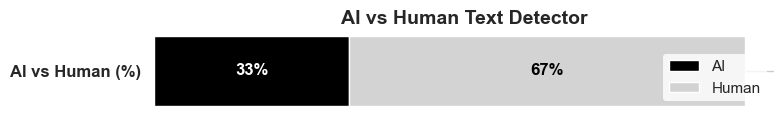

In [27]:
# --- Model Predictions ---

def model_preds(text):
    
    # Tf-Idf for MNB and SVC
    tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
    tfidf.fit(X_train)
    text_clean = clean_text(text)
    text_tfidf = tfidf.transform([text_clean])

    # Pad and Tokenizer for FFN
    seq = tokenizer.texts_to_sequences([text_clean])
    seq_pad = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

    # Vectorizer and Contreoid Calculation for Cosine Similarity
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X = vectorizer.fit_transform(df['clean_text'])
    ai_vectors = X[df['generated'] == 1]     # AI class
    human_vectors = X[df['generated'] == 0]  # Human class
    ai_centroid = np.asarray(ai_vectors.mean(axis=0)).reshape(1, -1)
    human_centroid = np.asarray(human_vectors.mean(axis=0)).reshape(1, -1)
    new_vec = vectorizer.transform([text_clean])

    # Multinomial Naive Bayes (MNB) Predictions
    mnb_probs = best_mnb.predict_proba(text_tfidf)[0]
    human_prob_mnb = mnb_probs[0]
    ai_prob_mnb = (1 - human_prob_mnb)

    # Linear Support Vector Classifier (Linear SVC) Predictions
    score = best_svc.decision_function(text_tfidf)[0]
    ai_prob_svc = 1 / (1 + np.exp(score))
    human_prob_svc = 1 - ai_prob_svc

    # Lightweight Deep Learning Predictions 
    ai_prob_ffn = model_ffn.predict(seq_pad)[0][0]
    human_prob_ffn = (1 - ai_prob_ffn)

    # Ensemble of 3 models
    human_total = int(round(((human_prob_mnb + human_prob_ffn + human_prob_svc) / 3)*100,0))
    ai_total = int(round(((ai_prob_mnb + ai_prob_ffn + ai_prob_svc) / 3)*100,0))

    return human_total, ai_total

# --- Model Comparison ---
sample_text = input("Input Text: ")
human, ai = model_preds(sample_text)

models = ["AI vs Human (%)"]
ai_probs = np.array([ai])
human_probs = np.array([human])

y_pos = np.arange(len(models))
bar_width = 0.5

plt.figure(figsize=(8,1))
plt.barh(y_pos, ai_probs, color='black', height=bar_width, label="AI")
plt.barh(y_pos, human_probs, left=ai_probs, color='lightgray', height=bar_width, label="Human")

for i, (a, h) in enumerate(zip(ai_probs, human_probs)):
    plt.text(a/2, i, f"{int(a)}%", va='center', ha='center', color='white', fontsize=12, weight='bold')
    plt.text(a + h/2, i, f"{int(h)}%", va='center', ha='center', color='black', fontsize=12, weight='bold')


plt.yticks(y_pos, models, fontsize=12, weight='bold')
plt.xticks([])
plt.legend(loc='lower right', facecolor='white', edgecolor='none')
plt.title("AI vs Human Text Detector", fontsize=14, weight='bold')
plt.box(False)
plt.show()

### **User Interface**

In [29]:
import tkinter as tk
from tkinter import scrolledtext
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# --- Main Screen ---
root = tk.Tk()
root.title("AI vs Human Text Classifier")
root.geometry("900x600")

# --- Headline ---
title_label = tk.Label(root, text="🤖 AI vs Human Text Classifier", font=("Segoe UI", 16, "bold"))
title_label.pack(pady=10)

# --- Text Box ---
text_label = tk.Label(root, text="Enter your text below:", font=("Segoe UI", 12))
text_label.pack()
text_box = scrolledtext.ScrolledText(root, width=100, height=8, font=("Segoe UI", 11))
text_box.pack(pady=5)

# --- Graph Frame ---
fig_frame = tk.Frame(root)
fig_frame.pack(pady=10, fill=tk.BOTH, expand=True)

# --- Model Predictions ---
def model_preds(text):
    text_clean = clean_text(text)
    
    # Tf-Idf for MNB and SVC
    tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
    tfidf.fit(X_train)
    text_clean = clean_text(text)
    text_tfidf = tfidf.transform([text_clean])

    # Pad and Tokenizer for FFN
    seq = tokenizer.texts_to_sequences([text_clean])
    seq_pad = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

    # Vectorizer and Contreoid Calculation for Cosine Similarity
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X = vectorizer.fit_transform(df['clean_text'])
    ai_vectors = X[df['generated'] == 1]     # AI class
    human_vectors = X[df['generated'] == 0]  # Human class
    ai_centroid = np.asarray(ai_vectors.mean(axis=0)).reshape(1, -1)
    human_centroid = np.asarray(human_vectors.mean(axis=0)).reshape(1, -1)
    new_vec = vectorizer.transform([text_clean])

    # Multinomial Naive Bayes (MNB) Predictions
    mnb_probs = best_mnb.predict_proba(text_tfidf)[0]
    human_prob_mnb = mnb_probs[0]
    ai_prob_mnb = (1 - human_prob_mnb)

    # Linear Support Vector Classifier (Linear SVC) Predictions
    score = best_svc.decision_function(text_tfidf)[0]
    ai_prob_svc = 1 / (1 + np.exp(score))
    human_prob_svc = 1 - ai_prob_svc

    # Lightweight Deep Learning Predictions 
    ai_prob_ffn = model_ffn.predict(seq_pad)[0][0]
    human_prob_ffn = (1 - ai_prob_ffn)

    # Ensemble of 3 models
    human_total = int(round(((human_prob_mnb + human_prob_ffn + human_prob_svc) / 3)*100,0))
    ai_total = int(round(((ai_prob_mnb + ai_prob_ffn + ai_prob_svc) / 3)*100,0))

    return human_total, ai_total

def analyze_text():
    sample_text = text_box.get("1.0", tk.END).strip()
    if not sample_text:
        return

    human_total, ai_total = model_preds(sample_text)

    labels = ["AI", "Human"]
    values = [ai_total, human_total]
    colors = ["black", "lightgray"]

    fig = plt.Figure(figsize=(5, 3))
    ax = fig.add_subplot(111)
    bars = ax.bar(labels, values, color=colors, width=0.5)

    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, val + 1, f"{val:.1f}%", 
                ha='center', va='bottom', fontsize=12, weight='bold')

    ax.set_ylim(0, 110)
    ax.set_ylabel("Prediction (%)", fontsize=11, weight='bold')
    ax.set_title("AI vs Human Classification Result", fontsize=13, weight='bold')
    ax.set_facecolor("white")
    fig.patch.set_facecolor("white")

    for widget in fig_frame.winfo_children():
        widget.destroy()

    canvas = FigureCanvasTkAgg(fig, master=fig_frame)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    results_text = f"🧠 AI: {ai_total:.1f}%\n👤 Human: {human_total:.1f}%"
    results_label.config(text=results_text)

analyze_btn = tk.Button(root, text="Analyze", command=analyze_text,
                        font=("Segoe UI", 12, "bold"), bg="#4CAF50", fg="white")
analyze_btn.pack(pady=10)

results_label = tk.Label(root, text="", font=("Segoe UI", 12, "bold"), justify="center")
results_label.pack(pady=5)

root.mainloop()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
